### Purpose of the Notebook

In [44]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rc
from matplotlib.ticker import AutoMinorLocator
import pickle
rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])
import numpyro

from jax import random, vmap
import jax
import jax.numpy as jnp
from numpyro.distributions import MultivariateNormal, Normal, LogNormal, RightTruncatedDistribution
from numpyro.infer import init_to_mean, init_to_value
import warnings
from common_util import LogLinearArrhenius,LogLinearArrheniusModelFunc, setup_axis_default

from typing import Callable
from scipy.optimize import minimize_scalar

def brute_force_opt_scaler(func: Callable,
                           bounds: np.ndarray,
                           num_divisions: int = 20) -> np.ndarray:
    
    x0 = np.linspace(bounds[0],bounds[1],num_divisions + 1)
    x = np.empty(num_divisions)
    opt = np.ones_like(x)*np.inf
    for i in range(num_divisions):
        opt_result = minimize_scalar(func,bounds = [x0[i],x0[i+1]],method = 'bounded')
        opt[i] = opt_result.fun
        x[i] = opt_result.x
    
    return x[np.argmin(opt)]

def read_prepare_data(file: str,
                      mult = 1.,
                      exclude_func: Callable = None) -> pd.DataFrame:
    
    """
    helper function to read data from file and make sure that the values
    are within the bounds of the model. Also make sure that standard 
    deviations are above some minimum value that I couldn't estimate
    from the plots.
    """
    df = pd.read_csv(file,index_col = 0)
    if exclude_func is not None:
        df = exclude_func(df)
        
    
    df['time']*=mult
    t = df['time'].to_numpy()
    T = df['temperature'].to_numpy() + 273.15
    X = df['X'].to_numpy()
    X[X <= 0 ] = 0.0
    X[X >= 1] = 1
    with warnings.catch_warnings(action = 'ignore'):
        try:
            df.loc[df['std'] == 0,'std'] = max(np.min(df.loc[df['std'] > 0,'std']),0.1e-3)
        except KeyError as ke:
            df.loc[:,'std'] = (1e-3)**0.5
            print(f'KeyError: {str(ke)} in file {file}')
    

    return t,T,X,df

file_to_label  = {'rf_data/alfonso_data/highly_rolled.csv': 'Lopez et al. (2015) - HR',
                'rf_data/alfonso_data/moderate_roll.csv': 'Lopez et al. (2015) - MR',
                'rf_data/richou_data/batch_a_data.csv': 'Richou et al. (2020) - Batch A',
                'rf_data/richou_data/batch_b_data.csv': 'Richou et al. (2020) - Batch B',
                 'rf_data/yu_data/data.csv': 'Yu et al. (2017)'}

file_to_model =  {'rf_data/alfonso_data/highly_rolled.csv': 'alfonso_data_hr',
                'rf_data/alfonso_data/moderate_roll.csv': 'alfonso_data_mr',
                'rf_data/richou_data/batch_a_data.csv': 'richou_batch_a',
                'rf_data/richou_data/batch_b_data.csv': 'richou_batch_b',
                 'rf_data/yu_data/data.csv': 'yu'}

file_to_multiplier = {'rf_data/alfonso_data/highly_rolled.csv': 3600.,
                      'rf_data/alfonso_data/moderate_roll.csv': 3600.,
                        'rf_data/richou_data/batch_a_data.csv': 1.0,
                        'rf_data/richou_data/batch_b_data.csv': 1.0,
                        'rf_data/yu_data/data.csv': 3600}

class DropTemp:

    def __init__(self,drop_temp: float):
        self.drop_temp = drop_temp

    def __call__(self,df: pd.DataFrame) -> np.ndarray:
        return df.loc[df['temperature'] != self.drop_temp]
    

def get_loglinear_arrhenius_parameter_bounds_from_file(plabel: str,
                                             file: str,
                                             alpha = 1e-3):
    
    """
    read log-linear arrhenius model from file (approx. estimated in seperate notebook),
    and provide nonlinear optimization bounds for the parameters
    """
    
    label = file_to_label[file]
    with open(f'.model/{plabel}_{label}_first_{2}.pkl','rb') as f:
        ols_res_f = pickle.load(f).parameter_confidence_interval(alpha)
    
    with open(f'.model/{plabel}_{label}_last_{2}.pkl','rb') as f:
        ols_res_l = pickle.load(f).parameter_confidence_interval(alpha)
    
    ci = np.concatenate([ols_res_f,
                         ols_res_l],axis = 1)
    
    bounds = np.array([np.min(ci,axis = 1),np.max(ci,axis = 1)]).T
    return bounds,bounds.mean(axis = 1)

def gl_fit_model_setup(file: str,
                       bounds_nu: np.ndarray = np.array([[1e-3,1.0]]),
                       mult = 1.,
                        exclude_func: Callable = None,
                       **kwargs):

    """
    neccssary setup for fitting the GL model
    """
    bounds_B,p0_B = get_loglinear_arrhenius_parameter_bounds_from_file('log_B',file,**kwargs)
    bounds_M,p0_M = get_loglinear_arrhenius_parameter_bounds_from_file('log_tinc',file, **kwargs)
    bounds = np.concatenate([bounds_nu,bounds_B,bounds_M],axis = 0)
    p0 = np.concatenate([p0_B,p0_M])
    return *read_prepare_data(file,mult = mult,exclude_func = exclude_func),bounds,p0

def jmak_fit_model_setup(file: str,
                         bounds_n: np.ndarray = np.array([[1.0,3.0]]),
                         mult = 1.,
                         exclude_func: Callable = None,
                         **kwargs):
    
    """
    neccssary setup for fitting the JMAK model
    """
    bounds_tinc,p0_tinc = get_loglinear_arrhenius_parameter_bounds_from_file('log_tinc',file,**kwargs)
    bounds_b,p0_b = get_loglinear_arrhenius_parameter_bounds_from_file('log_b',file, **kwargs)
    bounds = np.concatenate([bounds_n,bounds_b,bounds_tinc],axis = 0)
    p0 = np.concatenate([p0_b,p0_tinc])
    return *read_prepare_data(file, mult = mult,exclude_func = exclude_func),bounds,p0

def get_arrhenius_process_params(ap: LogLinearArrhenius) -> np.ndarray:
    return ap.params[0],ap.params[1]

def get_model_ap_params(model: LogLinearArrheniusModelFunc) -> np.ndarray:
    return (*get_arrhenius_process_params(model.ap1),*get_arrhenius_process_params(model.ap2))

def get_model_params(model: LogLinearArrheniusModelFunc) -> np.ndarray:
    return *get_model_ap_params(model),model.n


### JMAK Model Inference

In [ ]:

rng_key = random.PRNGKey(105)
rng_key, rng_key_ = random.split(rng_key)

def jmak_numpyro_model(t: jnp.ndarray,
                      T: jnp.ndarray,
                      X: jnp.ndarray,
                      std: jnp.ndarray,
                      pmean: jnp.ndarray,
                      pstd: jnp.ndarray) -> None:
    """
    numpyro/jax numpy compatible model for the JMAK model
    """

    # priors
    a1 = numpyro.sample('a1',Normal(pmean[0],pstd[0]))
    a2 = numpyro.sample('a2',Normal(pmean[2],pstd[2]))
    B1 = numpyro.sample('B1',Normal(pmean[1],pstd[1]))
    B2 = numpyro.sample('B2',Normal(pmean[3],pstd[3]))
    n = numpyro.sample('n',LogNormal(pmean[4]/2))

    sigma = numpyro.sample('sigma',numpyro.distributions.Exponential(10.0))

    # arrhenius equations
    b = jnp.exp(a1 + B1/T)
    t_inc = jnp.exp(a2 + B2/T)

    #model prediction
    Xhat = 1.0 - jnp.exp(-b**n*(jnp.where(t > t_inc, t,t_inc) - t_inc)**n)
    
    # likelihood
    with numpyro.plate("data", t.shape[0]):
        numpyro.sample('obs',Normal(Xhat,scale = sigma*std),obs = X)

model_name = 'JMAK_{}'

file = 'rf_data/yu_data/data.csv'

t,T,X,df,bounds,p0 = jmak_fit_model_setup(file, mult = file_to_multiplier[file])

pstd= (bounds[:,1] - bounds[:,0])/4
pstd = pstd[1:]

#read in least squares estimates
with open(f'.model/{model_name.format(file_to_model[file])}_weighted.pkl','rb') as f:
    a1,B1,a2,B2,n = get_model_params(pickle.load(f))

init_values = {'a1': a1,
               'a2': a2,
               'B1': B1,
               'B2': B2,
               'n': n,
               'sigma': 1.}

p0 = np.array([a1,B1,a2,B2,n])

nuts_kernel = numpyro.infer.NUTS(jmak_numpyro_model,init_strategy= init_to_value(values = init_values))

mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_samples=10000,
    num_warmup=10000,
    num_chains= 1,
)

mcmc.run(rng_key_,jnp.array(t),jnp.array(T),jnp.array(X),jnp.array(df['std'].to_numpy()),
         jnp.array(p0),jnp.array(pstd),init_params= init_values)

mcmc.print_summary()


KeyError: 'std' in file rf_data/yu_data/data.csv


sample: 100%|██████████| 20000/20000 [00:21<00:00, 940.26it/s, 42 steps of size 1.58e-02. acc. prob=0.89]  



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        B1 -17212.17   2715.04 -17152.30 -21456.46 -12786.33    197.81      1.00
        B2  39337.24   4542.40  39302.50  31850.95  46805.39    422.37      1.00
        a1      2.07      1.74      2.04     -0.86      4.70    197.17      1.00
        a2    -17.79      3.02    -17.75    -22.64    -12.73    427.25      1.00
         n      1.03      0.03      1.02      1.00      1.07    499.99      1.00
     sigma      1.78      0.18      1.78      1.49      2.07    598.80      1.00

Number of divergences: 8386


### JMAK Parameter Marginal Posterior Visualization

C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_36568\1913515524.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  opt[i] = opt_result.fun
C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_36568\1913515524.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = opt_result.x


            mean          std            ml
B1 -17212.171875  2714.903320 -17051.469831
B2  39337.242188  4542.168457  39381.324302
a1      2.073524     1.744135      1.974002
a2    -17.791908     3.023559    -17.736482
n       1.030551     0.033218      1.012267


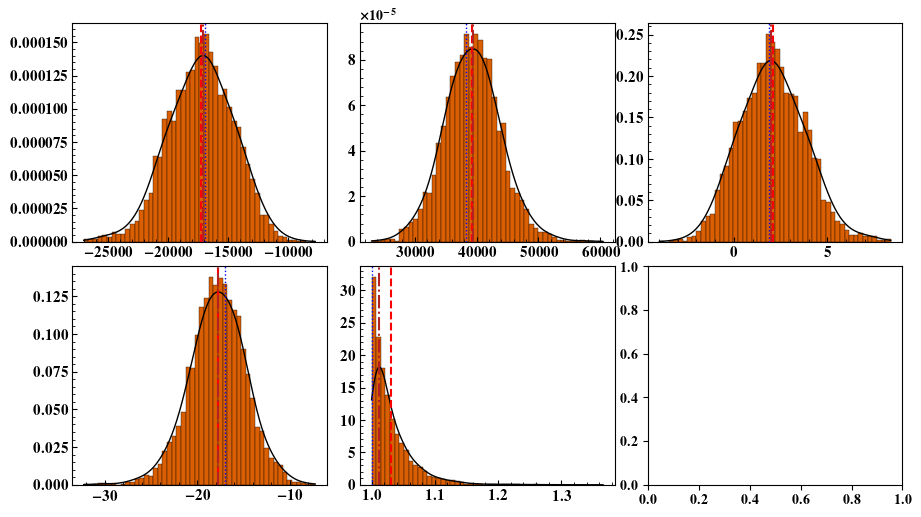

In [46]:
from scipy.stats import gaussian_kde

posterior_samples = mcmc.get_samples()

with open(f'.inference/{model_name.format(file_to_label[file])}_samples.pkl','wb') as f:
    pickle.dump(posterior_samples,f)

mean_values = np.mean(np.array(list(posterior_samples.values())),axis = 1)[:-1]
std_values = np.std(np.array(list(posterior_samples.values())),axis = 1)[:-1]
ml_values = []

fig,axes = plt.subplots(figsize = (9,5),nrows = 2,ncols = 3)
xlabels = {'a1': r'$a_1$',
            'a2': r'$a_2$',
            'B1': r'$B_1$',
            'B2': r'$B_2$',
            'n': r'$n$'}

params = pd.DataFrame({'mean': mean_values,
                       'std': std_values},
                      index = list(posterior_samples.keys())[:-1])

for ax,key in zip(np.ravel(axes)[:-1],posterior_samples.keys()):
    setup_axis_default(ax)
    ax.hist(np.array(posterior_samples[key]),bins = 50,edgecolor = 'k',
            color = plt.get_cmap('Dark2')(0.2),density = True,lw = 0.25)
    
    scale = posterior_samples[key].std()
    kde = gaussian_kde(np.array(posterior_samples[key])[::3],bw_method = 0.35)

    x = np.linspace(np.min(posterior_samples[key]),np.max(posterior_samples[key]),1000)
    pde_plot = kde(x)
    ml = brute_force_opt_scaler(lambda xx: -kde(xx),[x[0],x[-1]])

    ax.plot(x,pde_plot,color = 'k',lw = 1.0)
    ax.axvline(init_values[key],color = 'blue',lw = 1.0,ls = ':')
    ax.axvline(params['mean'][key],color = 'r',lw = 1.5,ls = '--')
    ax.axvline(ml,color = 'firebrick',lw = 1.5,ls = '-.')
    ml_values.append(ml)

fig.tight_layout(pad = 0.1)


params['ml'] = np.array(ml_values)
print(params)
params.to_csv(f'.inference/{model_name.format(file_to_label[file])}_params.csv') 


### JMAK Posterior Predictive Inference

KeyError: 'std' in file rf_data/yu_data/data.csv


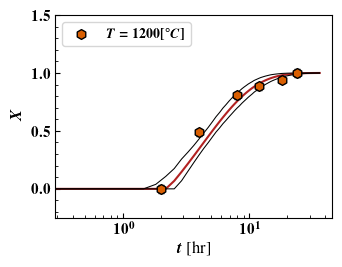

In [53]:
file = 'rf_data/yu_data/data.csv'

def jmak_model(t: np.ndarray,T:np.ndarray,a1,B1,a2,B2,n) -> np.ndarray:
    b = np.exp(a1 + B1/T)
    t_inc = np.exp(a2 + B2/T)
 
    return 1.0 - np.exp(-b**n*(np.where(t > t_inc, t,t_inc) - t_inc)**n)

model_name = 'JMAK_{}'

with open(f'.inference/{model_name.format(file_to_label[file])}_samples.pkl','rb') as f:
    posterior_samples = pickle.load(f)

jmak_posterior_predictive = numpyro.infer.Predictive(jmak_numpyro_model,posterior_samples= posterior_samples)
t,T,X,df,bounds,p0 = jmak_fit_model_setup(file, mult = file_to_multiplier[file])

fig,ax = plt.subplots(figsize = (3.25,2.5))
setup_axis_default(ax)

colors = plt.get_cmap('Dark2')(np.array([0.2,0.3]))
for kk_,plot_temp,scolor in zip(range(2),[1200],colors):
    data = df.loc[df['temperature'] == plot_temp]

    inf_summary = pd.read_csv(f'.inference/{model_name.format(file_to_label[file])}_params.csv',index_col = 0)

    pstd= (bounds[:,1] - bounds[:,0])/4
    pstd = pstd[1:]

    #read in least squares estimates
    B1,B2,a1,a2,n = inf_summary.loc[['B1','B2','a1','a2','n'],'ml'].to_numpy()

    p0 = np.array([a1,B1,a2,B2,n])

    t = np.linspace(0,data['time'].max()*1.5,100)

    mean_std= data['std'].mean()    
    predictions = jmak_posterior_predictive(rng_key_,t = jnp.array(t),
                                                    T = jnp.ones_like(t)*plot_temp + 273.15,
                                                    X = None,
                                                    std = jnp.zeros_like(t),
                                                    pmean = p0,
                                                    pstd = pstd)

    map_est = jmak_model(t,(plot_temp + 273.15)*np.ones_like(t),
                        a1,B1,a2,B2,n)


    lower,upper = numpyro.diagnostics.hpdi(predictions['obs'],0.95)

    ax.plot(t/3600,map_est,color = 'firebrick',lw = 1.5)
    ax.plot(t/3600,lower,color = 'k',lw = 0.75,ls = '-')
    ax.plot(t/3600,upper,color = 'k',lw = 0.75,ls = '-')  
    ax.set_xlabel(r'$t$ [hr]',fontsize = 12)
    ax.set_ylabel(r'$X$',fontsize = 12)

    ax.scatter(data['time']/3600,data['X'],facecolor = scolor,s = 50,
            edgecolor = 'k',zorder = 100,marker = 'h',
            label = r'\textbf{$T = ' + f'{plot_temp}$' + r'[$^\circ C $]}' if kk_ == 0 else  r'\textbf{' rf'${plot_temp}$' + r'[$^\circ C $]}')

    ax.errorbar(data['time']/3600,data['X'],yerr = data['std'],color = 'k',
                fmt = 'none',capsize = 2,elinewidth = 0.5)


ax.set_xscale('log')    
ax.legend(fontsize = 10,ncol = 2,loc = 'upper left')
ax.set_ylim([-0.25,1.5])
fig.tight_layout(pad = 0.1) 
#fig.savefig('.temp_images/jmak_fit_alfonso_highly_rolled_extrap.svg')


### Generalized Logistic Model Inference

In [54]:
rng_key = random.PRNGKey(54)
rng_key, rng_key_ = random.split(rng_key)

def glm_numpyro_model(t: jnp.ndarray,
                      T: jnp.ndarray,
                      X: jnp.ndarray,
                      std: jnp.ndarray,
                      pmean: jnp.ndarray,
                      pstd: jnp.ndarray) -> None:
    """
    numpyro/jax numpy compatible model for the glm
    """

    # priors
    a1 = numpyro.sample('a1',Normal(pmean[0],pstd[0]))
    a2 = numpyro.sample('a2',Normal(pmean[2],pstd[2]))
    B1 = numpyro.sample('B1',Normal(pmean[1],pstd[1]))
    B2 = numpyro.sample('B2',Normal(pmean[3],pstd[3]))
    nu = numpyro.sample('nu',LogNormal(pmean[4]))

    sigma = numpyro.sample('sigma',numpyro.distributions.Exponential(10.0))

    # arrhenius equations
    B = jnp.exp(a1 + B1/T)
    M = jnp.exp(a2 + B2/T)

    #model prediction
    Xhat = (1.+ jnp.exp(-B*(t - M)))**(-1./nu)
    
    # likelihood
    with numpyro.plate("data", X.shape[0]):
        numpyro.sample('obs',Normal(Xhat,scale = sigma*std),obs = X)

model_name = 'Generalized Logistic_{}'

file = 'rf_data/yu_data/data.csv'

t,T,X,df,bounds,p0 = gl_fit_model_setup(file, mult = file_to_multiplier[file])
pstd= (bounds[:,1] - bounds[:,0])/4
pstd = pstd[1:]

#read in least squares estimates
with open(f'.model/{model_name.format(file_to_model[file])}_weighted.pkl','rb') as f:
    a1,B1,a2,B2,nu = get_model_params(pickle.load(f))

init_values = {'a1': a1,
               'a2': a2,
               'B1': B1,
               'B2': B2,
               'nu': nu,
               'sigma': 1.}

p0 = np.array([a1,B1,a2,B2,nu])

nuts_kernel = numpyro.infer.NUTS(glm_numpyro_model,init_strategy= init_to_mean)

mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_samples=10000,
    num_warmup=15000,
    num_chains= 1,
)

mcmc.run(rng_key_,jnp.array(t),jnp.array(T),jnp.array(X),jnp.array(df['std'].to_numpy()),
         jnp.array(p0),jnp.array(pstd),init_params= init_values)

mcmc.print_summary()


KeyError: 'std' in file rf_data/yu_data/data.csv


sample: 100%|██████████| 25000/25000 [00:45<00:00, 543.99it/s, 127 steps of size 1.96e-02. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        B1 -22272.56   2394.99 -22290.06 -26174.62 -18339.64   1914.50      1.00
        B2 -17545.50  72477.67 -15682.83 -136766.41  97887.51   2329.82      1.00
        a1      5.85      1.57      5.86      3.38      8.49   1910.84      1.00
        a2    -46.36     45.59    -45.58   -123.08     26.70   2829.56      1.00
        nu      0.24      0.03      0.23      0.19      0.28   3207.93      1.00
     sigma      2.38      0.22      2.36      2.03      2.74   3697.13      1.00

Number of divergences: 1171


### Generalized Logistic Parameter Marginal Posterior Visualization

C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_36568\1913515524.py:34: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  opt[i] = opt_result.fun
C:\Users\mlanahan3\AppData\Local\Temp\ipykernel_36568\1913515524.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  x[i] = opt_result.x


            mean           std            ml
B1 -22272.562500   2394.866211 -22305.257750
B2 -17545.500000  72474.046875 -11487.148554
a1      5.854492      1.565513      5.883791
a2    -46.356831     45.590843    -44.394751
nu      0.235175      0.029063      0.232443


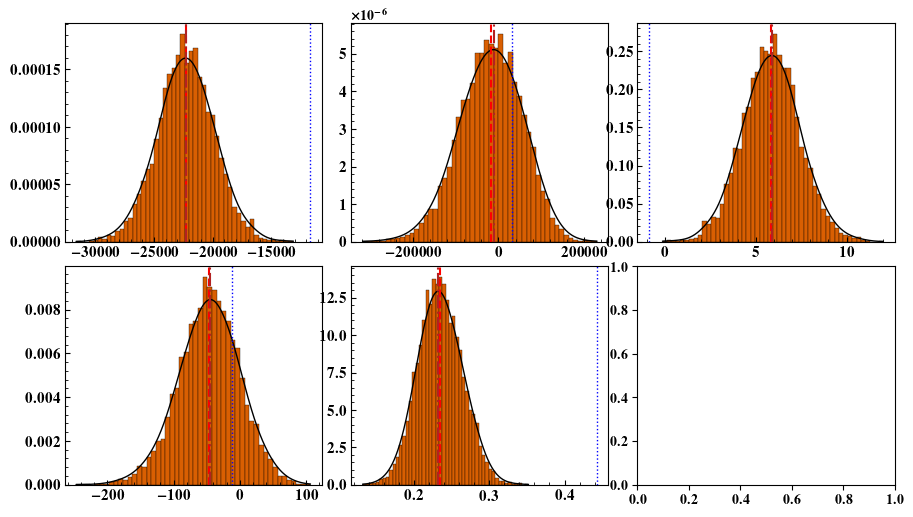

In [55]:
from scipy.stats import gaussian_kde

posterior_samples = mcmc.get_samples()

with open(f'.inference/{model_name.format(file_to_label[file])}_samples.pkl','wb') as f:
    pickle.dump(posterior_samples,f)

mean_values = np.mean(np.array(list(posterior_samples.values())),axis = 1)[:-1]
std_values = np.std(np.array(list(posterior_samples.values())),axis = 1)[:-1]
ml_values = []

fig,axes = plt.subplots(figsize = (9,5),nrows = 2,ncols = 3)
xlabels = {'a1': r'$a_1$',
            'a2': r'$a_2$',
            'B1': r'$B_1$',
            'B2': r'$B_2$',
            'nu': r'$\nu$'}
params = pd.DataFrame({'mean': mean_values,
                       'std': std_values},
                      index = list(posterior_samples.keys())[:-1])

for ax,key in zip(np.ravel(axes)[:-1],posterior_samples.keys()):
    setup_axis_default(ax)
    ax.hist(np.array(posterior_samples[key]),bins = 50,edgecolor = 'k',
            color = plt.get_cmap('Dark2')(0.2),density = True,lw = 0.25)
    
    scale = posterior_samples[key].std()
    kde = gaussian_kde(np.array(posterior_samples[key]),bw_method = 0.35)

    x = np.linspace(np.min(posterior_samples[key]),np.max(posterior_samples[key]),1000)
    pde_plot = kde(x)
    ml = brute_force_opt_scaler(lambda xx: -kde(xx),[x[0],x[-1]])

    ax.plot(x,pde_plot,color = 'k',lw = 1.0)
    ax.axvline(init_values[key],color = 'blue',lw = 1.0,ls = ':')
    ax.axvline(params['mean'][key],color = 'r',lw = 1.5,ls = '--')
    ax.axvline(ml,color = 'firebrick',lw = 1.5,ls = '-.')
    ml_values.append(ml)

fig.tight_layout(pad = 0.1)



params['ml'] = np.array(ml_values)
print(params)
params.to_csv(f'.inference/{model_name.format(file_to_label[file])}_params.csv') 


### JMAK Parameter Correlation

Observations:

1. $a_1$ and $a_2$ are nearly perfectly negatively correlated and have very low uncertainty in their values.
2. $B1$ and $a_1$ are fairly positively correlated
3. And so $a_2$ and $B_1$ are also fairly negatively correlated.
4. $B_2$ is fairly correlated to $\nu$.
5. The uncertainty is high enough in $B_1$ and $B_2$ due to Richou's data that much higher correlations between $a_1,a_2,B_1,B_2,\nu$ could exist.  quite plausibly.


It seems quite likely the parameters are linearly related between models, which suggests that:

$a_{1,i,j} = r_j c_1 + d_1$

$a_{2,i,j} = r_j c_2 + d_2$

$B_{1,i,j} = r_j c_3 + d_3$

$B_{2,i,j} = r_j c_4 + d_4$

$n_{i,j} = r_j c_5 + d_5$

where the parameters on the left hand side are the model material specific parameters, the parameters on the left are fixed across all models, and the parameter $\mathcal{R}_x$ is some scalar coefficient that represents the change in model predicted response due to the different models.

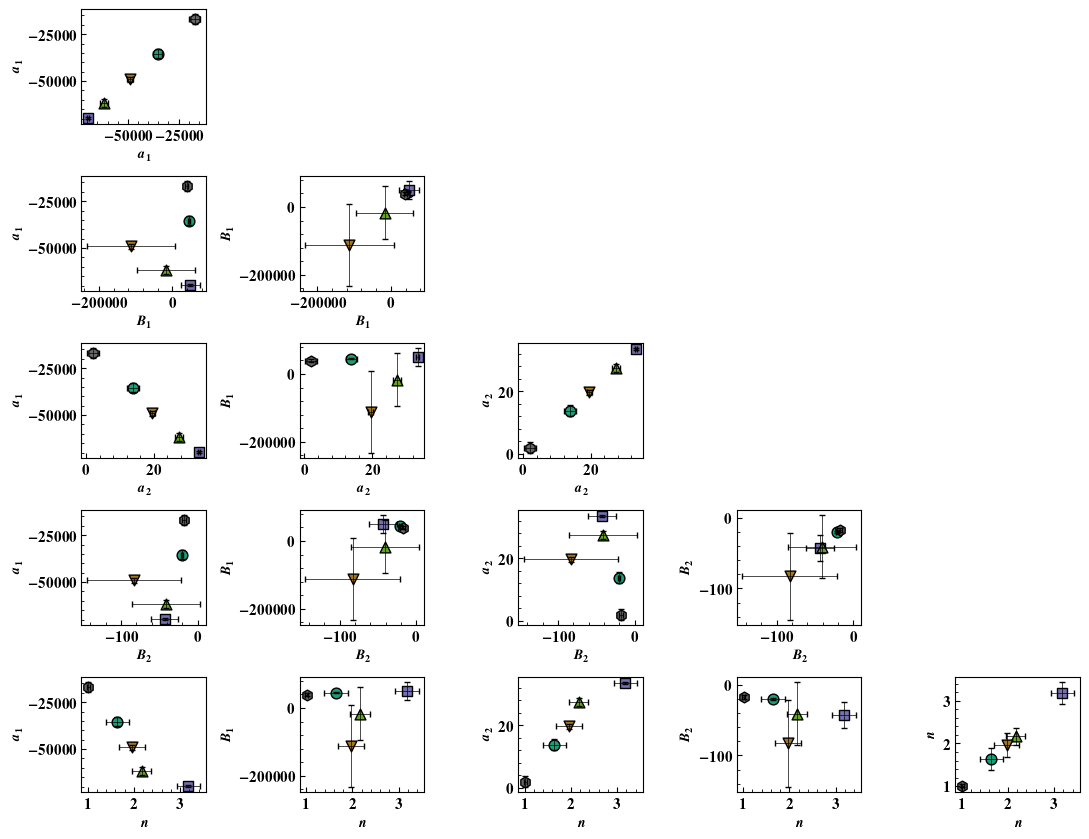

In [87]:
import math 
symbols = np.array(['o','s','^','v','h'])
colors = plt.get_cmap('Dark2')(np.linspace(0,1,len(file_to_label)))
ylabels = [r'$a_1$',r'$B_1$',r'$a_2$',r'$B_2$',r'$n$']

model_name = 'JMAK_{}'

T_1 = 800.0 + 273.15
T_2 = 2000.0 + 273.15
params = []
param_std = []
for data_name in file_to_label.values():
    inf_params = pd.read_csv(f'.inference/{model_name.format(data_name)}_params.csv')

    params.append(inf_params['ml'].to_numpy()[np.newaxis,:])
    param_std.append(inf_params['std'].to_numpy()[np.newaxis,:])


params = np.concatenate(params,axis = 0)
param_std = np.concatenate(param_std,axis = 0)

fig,axes = plt.subplots(nrows = params.shape[1],
                      ncols = params.shape[1],
                      figsize = (11,8.5))

for i in range(params.shape[1]):
    for j in range(i+1):
        for k in range(len(file_to_label)):
            axes[i,j].scatter(params[k,i],params[k,j],color = colors[k],marker = symbols[k],s = 60,
                              edgecolor = 'k')
            axes[i,j].errorbar(params[k,i],params[k,j],xerr = param_std[k,i ],yerr = param_std[k,j],
                               elinewidth = 0.5,capsize = 2,ls = 'none',color = 'k')

        axes[i,j].set_xlabel(ylabels[i])
        axes[i,j].set_ylabel(ylabels[j])
        setup_axis_default(axes[i,j])

    for j in range(i+1,params.shape[1]):
        axes[i,j].axis('off')

fig.tight_layout()

index_labels = [ylab[1:-1] for ylab in ylabels]
corr = pd.DataFrame(np.corrcoef(params,rowvar = False),
                    columns = index_labels,
                    index = index_labels)




Prior to bayesian inference estimate $r_j$ as $k_{eff,j}$, so we have $i$ observations

$a_{1,i,j} = k_{eff,i,j} c_1 + d_1$

$a_{2,i,j} = k_{eff,i,j} c_2 + d_2$

$B_{1,i,j} = k_{eff,i,j} c_3 + d_3$

$B_{2,i,j} = k_{eff,i,j} c_4 + d_4$

$n_{i,j} = k_{eff,i,j} c_5 + d_5$

If we flatten each data vector, we can then estimate a slope and intercept for each.

(50000,)
(50000,)
(50000,)
(50000,)
(50000,)


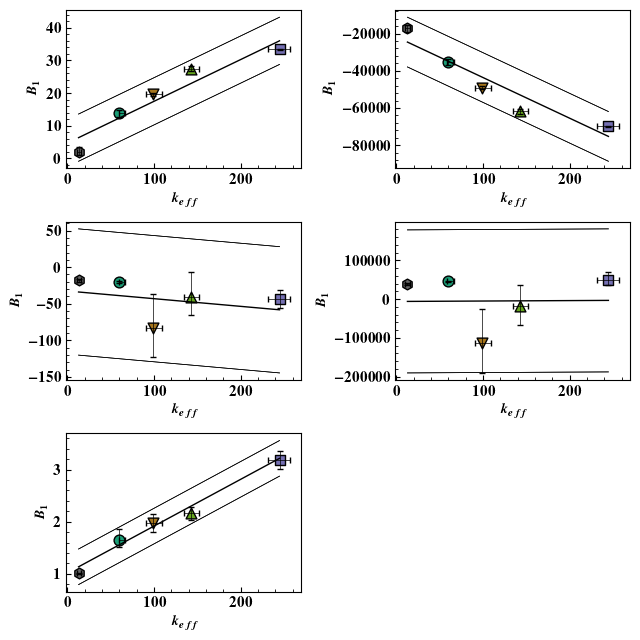

In [165]:
from common_util import hdi
from statsmodels.regression.linear_model import OLS
import copy

colors = plt.get_cmap('Dark2')(np.linspace(0,1,len(file_to_label)))
ylabels = [r'$a_1$',r'$B_1$',r'$a_2$',r'$B_2$',r'$n$']

model_name = 'JMAK_{}'

T_1 = 800.0 + 273.15
T_2 = 2000.0 + 273.15
params = []
ml_params = []
k_eff_ml = []
t_eff_ml = []

param_conf_int = np.zeros([2,len(ylabels),len(file_to_label)])
k_eff_conf_int = np.zeros([2,len(file_to_label)])
k_eff_samples = []

total_samples = []

for k,data_name in enumerate(file_to_label.values()):
    inf_params = pd.read_csv(f'.inference/{model_name.format(data_name)}_params.csv',index_col = 0)
    ml_params.append(inf_params.loc[['a1','B1','a2','B2','n'],'ml'].to_numpy()[:,np.newaxis])

    with open(f'.inference/{model_name.format(data_name)}_samples.pkl','rb') as f:
        posterior_samples = pickle.load(f)

    samples = pd.DataFrame.from_dict(posterior_samples)
    total_samples.append(samples)

    k_eff= samples['n']*samples['a1'] + samples['n']*samples['B1']/(T_1 - T_2)*math.log(T_2/T_1)
    k_eff_samples.append(k_eff)

    ols = OLS(k_eff,samples[['a1','B1','a2','B2','n']]).fit()

    k_eff_conf_int[:,k] = hdi(k_eff.to_numpy(),0.5)
    for j,col in enumerate(['a1','B1','a2','B2','n']):
        param_conf_int[:,j,k] = hdi(samples[col].to_numpy(),0.5)

    a1,B1,a2,B2,n = inf_params.loc[['a1','B1','a2','B2','n'],'ml'].to_numpy()
    k_eff_ml.append(n*a1 + n*B1/(T_1 - T_2)*math.log(T_2/T_1))


linear_models = []
k_eff = np.concatenate(k_eff_samples)
Xfit = np.array([np.ones(k_eff.shape[0]),k_eff]).T
total_samples = pd.concat(total_samples,axis = 0)   
for j,col in enumerate(['a1','B1','a2','B2','n']):
    yfit = total_samples[col].to_numpy()
    print(yfit.shape)
    ols = OLS(yfit[::10],Xfit[::10,:]).fit()  

    linear_models.append(copy.deepcopy(ols))

k_eff_ml = np.array(k_eff_ml)

scale_k = k_eff_ml.max() - k_eff_ml.min()
offset_k = k_eff_ml.min()

ml_params = np.concatenate(ml_params,axis = -1)

fig1,axes1 = plt.subplots(nrows = 3,ncols = 2,figsize = (6.5,6.5))
for i,ax in zip(range(5),axes1.ravel()):
    setup_axis_default(ax)
    for j in range(len(symbols)):
        ax.scatter(k_eff_ml[j],ml_params[i,j],color = colors[j],marker = symbols[j],s = 60,
                            edgecolor = 'k')
    
    k_eff_plot = np.linspace(k_eff_ml.min(),k_eff_ml.max(),100)
    Xplot = np.array([np.ones(k_eff_plot.shape[0]),k_eff_plot]).T
    ml_params_plot = linear_models[i].predict(Xplot)
    pred = linear_models[i].get_prediction(Xplot)
    ml_params_plot = pred.predicted_mean
    param_conf_int_plot = pred.conf_int(0.95)

    xerr = np.abs(k_eff_ml[np.newaxis,:] - k_eff_conf_int[...,:])
    yerr = np.abs(ml_params[np.newaxis,i,:] - param_conf_int[:,i,:])
    ax.errorbar(k_eff_ml,ml_params[i,:],yerr= yerr,xerr = xerr,
                        elinewidth = 0.5,capsize = 2,ls = 'none',color = 'k')
    
    for i in range(2):
        ax.plot(k_eff_plot,param_conf_int_plot[:,i],lw = 0.5,color = 'k',ls = ':')
        ax.plot(k_eff_plot,param_conf_int_plot[:,i],lw = 0.5,color = 'k',ls = ':')

    ax.fill_between(k_eff_plot,param_conf_int_plot[:,0],param_conf_int_plot[:,1],color = 'grey',alpha = 0.1)
    ax.plot(k_eff_plot,ml_params_plot,lw = 1.0,color = 'k') 
    ax.set_ylabel(ylabels[i])
    ax.set_xlabel(r'$k_{eff}$') 

axes1[2,1].axis('off')
fig1.tight_layout() 

### Bayesian Heirarchical Modeling

In [83]:
rng_key = random.PRNGKey(105)
rng_key, rng_key_ = random.split(rng_key)

def jmak_numpyro_model(t: jnp.ndarray,
                       T: jnp.ndarray,
                       X: jnp.ndarray,
                       std: jnp.ndarray,
                       model_index: jnp.ndarray,
                       latent_means: jnp.ndarray,
                       latent_std: jnp.ndarray,
                       rx_mean: float,
                       rx_std: float,
                       m: int) -> None:
                      
    """
    numpyro/jax numpy compatible model for the JMAK model
    """

    # priors for "latent" parameters
    c = numpyro.sample('c',Normal(latent_means[:,0],latent_std[:,0]))
    d = numpyro.sample('d',Normal(latent_means[:,1],latent_std[:,1]))
    Rx = numpyro.sample('Rx',Normal(rx_mean*jnp.ones(m),rx_std*jnp.ones(m)))
    
    #map latent parameters to model parameters
    rx = Rx[model_index]
    a1 = c[0]*rx + d[0]
    a2 = c[1]*rx + d[1]
    B1 = c[2]*rx + d[2]
    B2 = c[3]*rx + d[3]
    n = c[4]*rx + d[4]

    sigma = numpyro.sample('sigma',numpyro.distributions.Exponential(10.0))

    # arrhenius equations
    b = jnp.exp(a1 + B1/T)
    t_inc = jnp.exp(a2 + B2/T)

    #model prediction
    Xhat = 1.0 - jnp.exp(-b**n*(jnp.where(t > t_inc, t,t_inc) - t_inc)**n)
    
    # likelihood
    with numpyro.plate("data", t.shape[0]):
        numpyro.sample('obs',Normal(Xhat,scale = sigma*std),obs = X)